In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import scienceplots
from scipy.interpolate import interp1d
from scipy.differentiate import derivative
from scipy.optimize import root_scalar
from multiprocessing import Pool

In [2]:
data = pd.read_csv('mt_boson_list.csv', header=None)
data.iloc[:, 1] = data.iloc[:, 1].astype(str).str.replace(r'\*\^', 'e', regex=True).astype(float)

plt.style.use(['science'])

(0.0, 5.0)

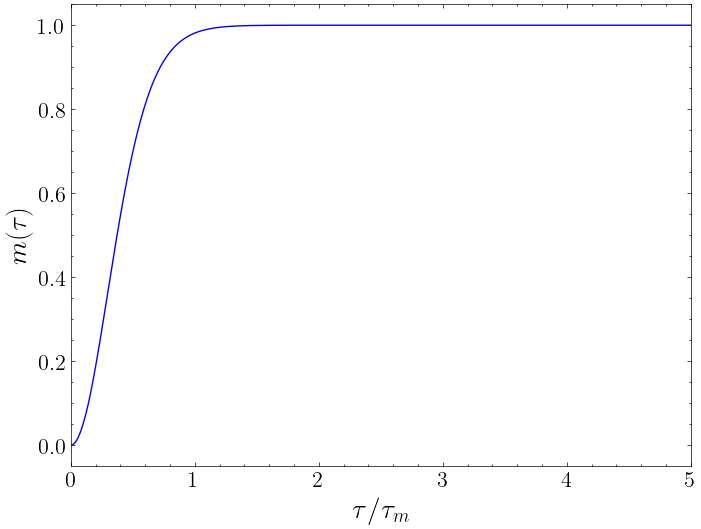

In [ ]:
#Plotting the mass profile
x = data.iloc[:,0]
y = data.iloc[:,1]

plt.figure(figsize=(8, 6))
plt.plot(x, y, label='Data', color='blue')
plt.xlabel(r'$\tau/\tau_{m}$', fontsize = 20)

plt.ylabel(r'$m(\tau)$', fontsize=20)
plt.tick_params(axis='both', labelsize=16)
# plt.xscale('log')
plt.xlim(0,5)

In [4]:
def m(mtau, tau_m=1.0):
    mtau_cop = mtau.copy()
    
    # Scale tau values by tau_m
    mtau_cop.iloc[:, 0] = tau_m * mtau_cop.iloc[:, 0]

    # Extract columns
    tau_pos = mtau_cop.iloc[:, 0].values
    m_pos = mtau_cop.iloc[:, 1].values

    # Create symmetric negative tau values
    tau_neg = -tau_pos
    m_neg = m_pos

    # Combine: (tau, m), (-tau, m), and (0, 0)
    tau_all = np.concatenate([tau_neg, [0.0], tau_pos])
    m_all = np.concatenate([m_neg, [0.0], m_pos])

    # Sort by tau to ensure interp1d gets ordered input
    sorted_idx = np.argsort(tau_all)
    tau_sorted = tau_all[sorted_idx]
    m_sorted = m_all[sorted_idx]

    # Interpolation
    mtau_interp = interp1d(tau_sorted, m_sorted, kind='cubic', fill_value='extrapolate')
    return mtau_interp

def m_prime(m,tau):
    return derivative(m, tau, maxiter=2, order=3)

### Testing the interpolation function

In [5]:
# Get positive τ values from data (should be strictly > 0)
tau_pos = data.iloc[:, 0].values

# Create the mass function m(τ) with τ_m = 1
m_tau_m_1 = m(data, tau_m=1)

# Compute m'(τ) at positive τ
m_prime_vals_pos = [m_prime(m_tau_m_1, tau).df for tau in tau_pos]

# Construct full τ and m' arrays: use odd symmetry for m'(τ)
tau_all = np.concatenate([-tau_pos[::-1], tau_pos])  # From negative to positive
m_prime_all = np.concatenate([-np.array(m_prime_vals_pos)[::-1], m_prime_vals_pos])

# Create interpolator over symmetric domain
m_prime_m_1 = interp1d(tau_all, m_prime_all, kind='cubic', fill_value='extrapolate')


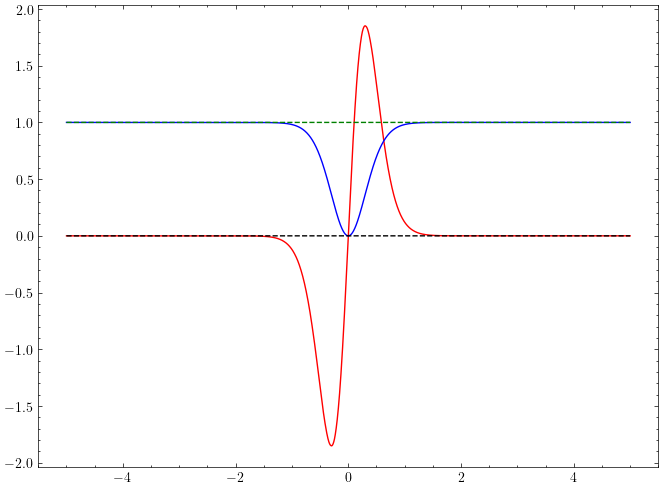

In [6]:
plt.figure(figsize=(8, 6))
plt.plot(np.linspace(-5, 5, 10000), m_prime_m_1(np.linspace(-5,5,10000)), label=r"$m'(\tau)$", color='red')
plt.plot(np.linspace(-5, 5, 10000), m_tau_m_1(np.linspace(-5, 5, 10000)), label=r"$m(\tau)$", color='blue')
# plt.xlim(0,1)
plt.plot(np.linspace(-5,5,10000), np.ones(10000), color = 'green', linestyle = '--')
plt.plot(np.linspace(-5,5,10000), np.zeros(10000), color = 'black', linestyle = '--')
plt.show()

### $\rm{cos}(2\phi) = 1\implies\tau={\tau}_{1}$:

In [7]:
mu_r = 3.0
mu_t = 100

def inverse_magnification(m,tau,phi=0):
    return (
        (((1/mu_r) - (m_prime(m,tau).df / (2.0 * tau)) ) * ((1/mu_t) - (m_prime(m,tau).df / (2.0 * tau)) )) -
        ((m_prime(m,tau).df / (2.0 * tau)) - (m(tau) / tau**2))**2 +
        (1/mu_r - 1/mu_t) * ((m_prime(m,tau).df / (2.0 * tau)) - (m(tau) / tau**2))*np.cos(2*phi)
    )

def inverse_magnification_vec(m_vals, m_prime_vals, tau_values, phi): #vectorized version of inverse_magnification
    term1 = (1/mu_r - m_prime_vals / (2.0 * tau_values))
    term2 = (1/mu_t - m_prime_vals / (2.0 * tau_values))
    term3 = (m_prime_vals / (2.0 * tau_values)) - (m_vals / tau_values**2)
    return term1 * term2 - term3**2 + (1/mu_r - 1/mu_t) * term3 * np.cos(2 * phi)

/tmp/ipykernel_6324/1107803296.py:6: RuntimeWarning: divide by zero encountered in divide
  (((1/mu_r) - (m_prime(m,tau).df / (2.0 * tau)) ) * ((1/mu_t) - (m_prime(m,tau).df / (2.0 * tau)) )) -
/tmp/ipykernel_6324/1107803296.py:7: RuntimeWarning: divide by zero encountered in divide
  ((m_prime(m,tau).df / (2.0 * tau)) - (m(tau) / tau**2))**2 +
/tmp/ipykernel_6324/1107803296.py:7: RuntimeWarning: invalid value encountered in divide
  ((m_prime(m,tau).df / (2.0 * tau)) - (m(tau) / tau**2))**2 +
/tmp/ipykernel_6324/1107803296.py:8: RuntimeWarning: divide by zero encountered in divide
  (1/mu_r - 1/mu_t) * ((m_prime(m,tau).df / (2.0 * tau)) - (m(tau) / tau**2))*np.cos(2*phi)
/tmp/ipykernel_6324/1107803296.py:8: RuntimeWarning: invalid value encountered in divide
  (1/mu_r - 1/mu_t) * ((m_prime(m,tau).df / (2.0 * tau)) - (m(tau) / tau**2))*np.cos(2*phi)


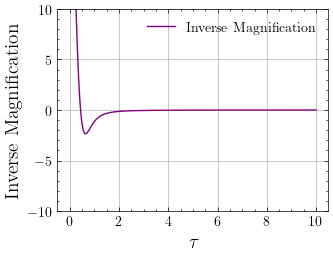

In [ ]:
# Plotting the inverse magnification

# Generate tau values
tau_values_ex = np.linspace(0,10,100000)

# Compute inverse magnification for each tau
inverse_mag = inverse_magnification(m=m_tau_m_1, tau=tau_values_ex, phi=0)

# Plot inverse magnification against tau
plt.plot(tau_values_ex, inverse_mag, label='Inverse Magnification', color='purple')
plt.xlabel(r'$\tau$', fontsize=14)
plt.ylabel('Inverse Magnification', fontsize=14)
plt.ylim(-10,10)
plt.legend()
plt.grid(True)
plt.show()

In [46]:
# Function to compute critical curves for a given tau_m and phi
def compute_caustics(tau_m, phi, tau_values_pos, tau_values_neg, data=data):
    m_tau = m(data, tau_m)
    m_vals_pos = np.array([m_tau(t) for t in tau_values_pos])
    m_prime_vals_pos = np.array([m_prime(m_tau, t).df for t in tau_values_pos])
    m_vals_neg = np.array([m_tau(t) for t in tau_values_neg])
    m_prime_vals_neg = np.array([m_prime(m_tau, t).df for t in tau_values_neg])

    im_vals_pos = inverse_magnification_vec(m_vals_pos, m_prime_vals_pos, tau_values_pos, phi)
    signs_pos = np.sign(im_vals_pos)
    pos_root_idxs = np.where(signs_pos[:-1] * signs_pos[1:] < 0)[0]

    im_vals_neg = inverse_magnification_vec(m_vals_neg, m_prime_vals_neg, tau_values_neg, phi)
    signs_neg = np.sign(im_vals_neg)
    neg_root_idxs = np.where(signs_neg[:-1] * signs_neg[1:] < 0)[0]

    roots_pos = []
    roots_neg = []
    for i in pos_root_idxs:
        wrapper = lambda x: inverse_magnification(m_tau, x, phi)
        a, b = tau_values_pos[i], tau_values_pos[i + 1]
   
        result = root_scalar(wrapper, bracket=[a, b], method='brentq')
        if result.converged:
            roots_pos.append(result.root)
    
    for i in neg_root_idxs:
        wrapper = lambda x: inverse_magnification(m_tau, x, phi)
        a, b = tau_values_neg[i], tau_values_neg[i + 1]
        
        result = root_scalar(wrapper, bracket=[a, b], method='brentq')
        if result.converged:
            roots_neg.append(result.root)

    roots = roots_pos + roots_neg
    return tau_m, roots, phi

# Parameters
phi = 0
tau_values_pos = np.linspace(0.001, 50, 10000)
tau_values_neg = np.linspace(-50, -0.001, 10000)
tau_m_values = np.linspace(0.1, 50, 500)

#Prepare arguments for starmap and parallel computation
args_list = [(tau_m,phi,tau_values_pos,tau_values_neg) for tau_m in tau_m_values]

# Parallel computation
with Pool() as pool:
    tau_caustics = pool.starmap(compute_caustics, args_list)

print(f"Roots found: {tau_caustics}")

Roots found: [(np.float64(0.1), [9.999999999999861, -9.99999999999986], 0), (np.float64(0.2), [9.999999999999861, -9.999999999999863], 0), (np.float64(0.3), [0.048067299845297826, 0.1416151114952394, 9.999999999999863, -9.999999999999863, -0.14161511149523895, -0.048067299845297916], 0), (np.float64(0.4), [0.19804441927417285, 9.99999999999986, -9.99999999999986, -0.19804441927417282], 0), (np.float64(0.5), [0.24220837441989082, 9.999999999999861, -9.999999999999861, -0.24220837441989085], 0), (np.float64(0.6), [0.285131271503542, 9.999999999999861, -9.999999999999863, -0.2851312715035419], 0), (np.float64(0.7), [0.32729792368448385, 9.999999999999861, -9.999999999999863, -0.327297923684484], 0), (np.float64(0.7999999999999999), [0.3683970368237637, 9.999999999999863, -9.999999999999863, -0.3683970368237638], 0), (np.float64(0.8999999999999999), [0.40823065873347464, 9.999999999999863, -9.999999999999865, -0.40823065873347497], 0), (np.float64(0.9999999999999999), [0.4465531073991189, 

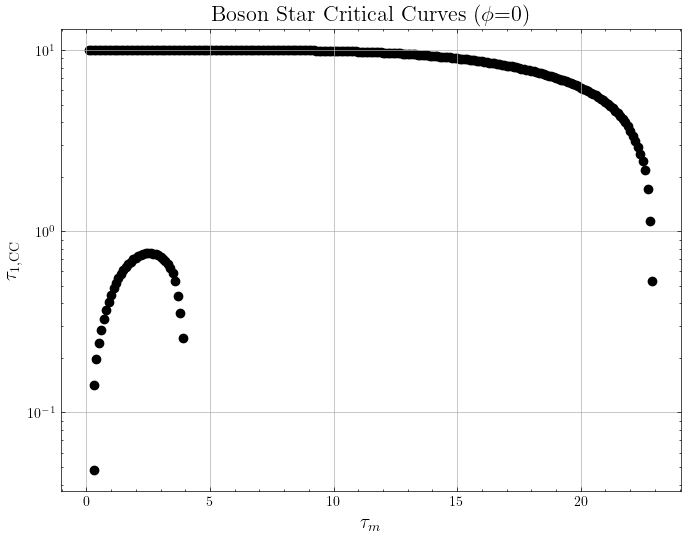

In [47]:
# Extract tau_m and roots from tau_caustics
tau_m_values_plot = [item[0] for item in tau_caustics]  # Extract tau_m values
roots = [item[1] for item in tau_caustics]   # Extract arrays of roots

# Plot each root as a scatter plot
plt.figure(figsize=(8, 6))
for i in range(max(len(r) for r in roots)):  # Iterate over the maximum number of roots
    # Extract the i-th root for all tau_m values (if it exists)
    root_values = [r[i] if i < len(r) else None for r in roots]
    tau_m_filtered = [tau_m_values_plot[j] for j in range(len(root_values)) if root_values[j] is not None]
    root_filtered = [root_values[j] for j in range(len(root_values)) if root_values[j] is not None]
    
    # Plot the i-th root
    plt.scatter(tau_m_filtered, root_filtered, label=f'Root {i+1}', color = 'black')

# Set axis scales and labels
plt.xscale('linear')  # Linear scale for tau_m
plt.yscale('log')     # Log scale for roots
plt.xlabel(r'$\tau_m$', fontsize=14)
plt.ylabel(r'$\tau_{1,\rm{CC}}$', fontsize=14)
plt.title(r'Boson Star Critical Curves ($\phi$=0)', fontsize=16)
plt.grid(True)

# Save the image as a PNG file
# plt.savefig('/home/bcrossey/Documents/Microlensing/Code/Microcaustics_EDOs/figures/boson_star_critical_curves_phi_0.png', dpi=300, format='png')

In [19]:
# Convert tau_caustics to a DataFrame
df = pd.DataFrame(tau_caustics, columns=['tau_m', 'roots'])

# Expand the roots column into separate columns for each root
roots_df = pd.DataFrame(df['roots'].tolist(), index=df.index)

# Rename the columns of roots_df to root_1, root_2, etc.
roots_df.columns = [f'root_{i+1}' for i in range(roots_df.shape[1])]

# Concatenate the tau_m column with the renamed roots DataFrame
df = pd.concat([df.drop(columns=['roots']), roots_df], axis=1)

# Save to a CSV file
df.to_csv('/home/bcrossey/Documents/Microlensing/Code/Microcaustics_EDOs/boson_star_critical_curves_phi_0.csv', index=False)

$\rm{cos}(2\phi) = -1\implies\tau={\tau}_{2}$:

In [25]:
# Parameters to compute roots for crossings in the tau_2 direction
phi_2 = np.pi / 2 
#Use same tau_values, tau_m_values as before

#Prepare arguments for starmap and parallel computation
args_list_2 = [(tau_m,phi_2,tau_values_pos,tau_values_neg) for tau_m in tau_m_values]

# Parallel computation
with Pool() as pool:
    tau_caustics_tau_2 = pool.starmap(compute_caustics, args_list_2)

print(f"Roots found: {tau_caustics_tau_2}")

Roots found: [(np.float64(0.1), [1.732050807568877, -1.732050807568877]), (np.float64(0.2), [1.7320508075688772, -1.732050807568877]), (np.float64(0.3), [0.041522511869169665, 0.14555806097905039, 1.7320508075688772, -1.7320508075688772, -0.14555806097905047, -0.04152251186916897]), (np.float64(0.4), [0.2016171690622466, 1.732050807568877, -1.732050807568877, -0.20161716906224658]), (np.float64(0.5), [0.24789499539854956, 1.7320508075688767, -1.732050807568877, -0.24789499539854945]), (np.float64(0.6), [0.29412570570800145, 1.7320508075688772, -1.7320508075688772, -0.2941257057080014]), (np.float64(0.7), [0.3410176948939715, 1.7320508075689574, -1.7320508075689574, -0.3410176948939714]), (np.float64(0.7999999999999999), [0.3882210310124136, 1.7320508077257177, -1.7320508077257177, -0.3882210310124139]), (np.float64(0.8999999999999999), [0.43555213940005466, 1.7320507000381462, -1.7320507000381458, -0.4355521394000546]), (np.float64(0.9999999999999999), [0.48291580780484267, 1.732013820

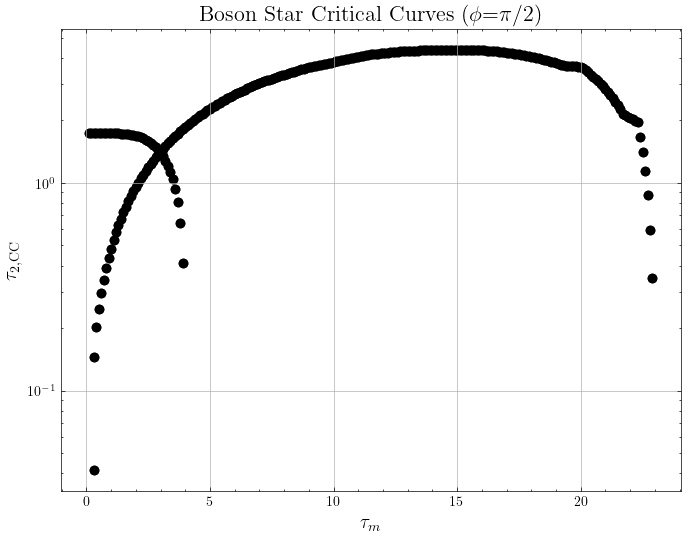

In [36]:
# Extract tau_m and roots from tau_caustics
tau_m_values_plot = [item[0] for item in tau_caustics_tau_2]  # Extract tau_m values
roots = [item[1] for item in tau_caustics_tau_2]   # Extract arrays of roots

# Plot each root as a scatter plot
plt.figure(figsize=(8, 6))
for i in range(max(len(r) for r in roots)):  # Iterate over the maximum number of roots
    # Extract the i-th root for all tau_m values (if it exists)
    root_values = [r[i] if i < len(r) else None for r in roots]
    tau_m_filtered = [tau_m_values_plot[j] for j in range(len(root_values)) if root_values[j] is not None]
    root_filtered = [abs(root_values[j]) for j in range(len(root_values)) if root_values[j] is not None]
    
    # Plot the i-th root
    plt.scatter(tau_m_filtered, root_filtered, label=f'Root {i+1}', color='black')

# Set axis scales and labels
plt.xscale('linear')  # Linear scale for tau_m
plt.yscale('log')     # Log scale for roots
plt.xlabel(r'$\tau_m$', fontsize=14)
plt.ylabel(r'$\tau_{2,\rm{CC}}$', fontsize=14)
plt.title(r'Boson Star Critical Curves ($\phi$=$\pi$/2)', fontsize=16)
plt.grid(True)

# Save the image as a PNG file
plt.savefig('/home/bcrossey/Documents/Microlensing/Code/Microcaustics_EDOs/figures/boson_star_critical_curves_phi_pi_over_2.png', dpi=300, format='png')

In [37]:
# Convert tau_caustics to a DataFrame
df = pd.DataFrame(tau_caustics_tau_2, columns=['tau_m', 'roots'])

# Expand the roots column into separate columns for each root
roots_df = pd.DataFrame(df['roots'].tolist(), index=df.index)

# Rename the columns of roots_df to root_1, root_2, etc.
roots_df.columns = [f'root_{i+1}' for i in range(roots_df.shape[1])]

# Concatenate the tau_m column with the renamed roots DataFrame
df = pd.concat([df.drop(columns=['roots']), roots_df], axis=1)

# Save to a CSV file
df.to_csv('/home/bcrossey/Documents/Microlensing/Code/Microcaustics_EDOs/boson_star_critical_curves_tau_2.csv', index=False)

## Plotting boson star caustic curves in the source plane

In [43]:
def lens_to_source_mapping(tau_m,tau,phi,data=data):
    m_tau = m(data, tau_m)
    u_1 = ((tau*np.cos(phi)) / mu_r) - ((tau*np.cos(phi))/tau**2)*(m_tau(tau))
    u_2 = ((tau*np.sin(phi)) / mu_t) - ((tau*np.sin(phi))/tau**2)*(m_tau(tau))
    return u_1, u_2

In [83]:
# Plotting the caustic curves in the source plane for a boson star with given tau_m

phi_values = np.linspace(0, 2 * np.pi, 100)
tau_m_value = 3

arguments = [(tau_m_value, phi, tau_values_pos, tau_values_neg) for phi in phi_values]

with Pool() as pool:
    critical_curve_results = pool.starmap(compute_caustics, arguments)
critical_tau1 = []
critical_tau2 = []

caustic_u1 = []
caustic_u2 = []

for tau_m, roots, phi in critical_curve_results:
    for tau in roots:
        # Critical curve in lens plane
        tau_1 = tau * np.cos(phi)
        tau_2 = tau * np.sin(phi)
        critical_tau1.append(tau_1)
        critical_tau2.append(tau_2)

        # Caustic curve in source plane
        u1, u2 = lens_to_source_mapping(tau_m, tau, phi, data)
        caustic_u1.append(u1)
        caustic_u2.append(u2)


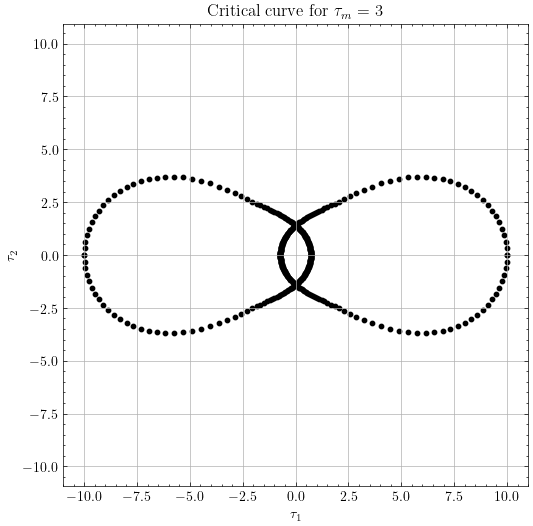

In [95]:
# Plot critical curve
plt.figure(figsize=(6, 6))
plt.scatter(critical_tau1, critical_tau2, color='black', s=10)
plt.xlabel(r"$\tau_1$")
plt.ylabel(r"$\tau_2$")
plt.title(r"Critical curve for $\tau_m$ = " + f'{tau_m_value}')
plt.axis('equal')
plt.grid(True)

# plt.savefig('/home/bcrossey/Documents/Microlensing/Code/Microcaustics_EDOs/figures/boson_star_critical_curve_tau_m_3.png', dpi=300, format='png')

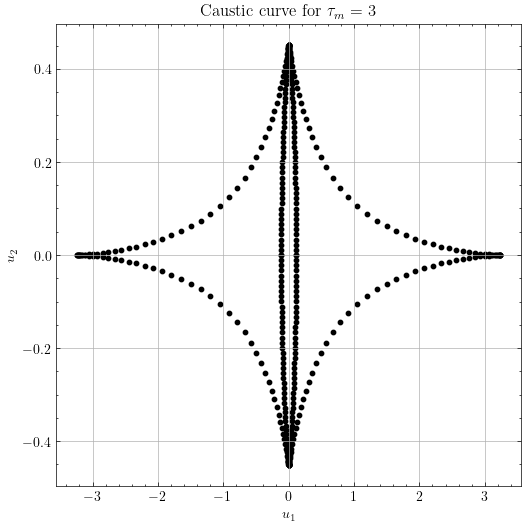

In [92]:
# Plot caustic curve
plt.figure(figsize=(6, 6))
plt.scatter(caustic_u1, caustic_u2, color='black', s=10)
plt.xlabel(r"$u_1$")
plt.ylabel(r"$u_2$")
plt.title(r"Caustic curve for $\tau_m$ = " + f'{tau_m_value}')
# plt.axis('equal')
plt.grid(True)

# plt.savefig('/home/bcrossey/Documents/Microlensing/Code/Microcaustics_EDOs/figures/boson_star_caustic_tau_m_3.png', dpi=300, format='png')